# Space Invaders: DQN implementation

By:

Andres Bermeo Marinelli

Davide Basso

# 0. Importing Space Invader environment.

To run the notebook, please be sure to download the ROM for SpaceInvaders. This is perhaps the most complicated step as some ROMS don't work while others do. 
We found that the version from 1983 (specifically) with a .a26 extension solved all issues. 

Lastly, to work easily in collaborative mode, we uploaded the ROM to a google drive folder named "space". The following code snippets operate on this assumption.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np           
from skimage import transform 
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import gym

import torch
import torch.nn as nn

import pickle


c:\Users\andre\anaconda3\envs\atari\lib\site-packages\ale_py\roms\__init__.py:89: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  ROMS = resolve_roms()


In [2]:
!python -m atari_py.import_roms ./Utils

copying space_invaders.bin from ../Utils\Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) ~.bin to c:\Users\andre\anaconda3\envs\atari\lib\site-packages\atari_py\atari_roms\space_invaders.bin


# 1. Environment Setting

We set the enviroment using gym module from OpenAI. We select the Space Invaders module after having imported the ROM from.

http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html

In [3]:
env = gym.make(id='SpaceInvadersNoFrameskip-v4')

print("State size:\t", env.observation_space.shape) #The frame size corresponds to the state space. 
print("Actions:\t", env.action_space.n)


State size:	 (210, 160, 3)
Actions:	 6


As we can see, our observation space, in the most basic form, consists of an rgb frame of size (210, 160, 3).
Furthermore, there are 6 possible actions to take:

  - 0 - Do nothing
  - 1 - Fire
  - 2 - Right
  - 3 - Left
  - 4 - Right Fire
  - 5 - Left Fire

An agent can take actions through the env.step(action) command, i.e env.step(0) tells the emulator to not do anything and advance the frame to the next state.

We show the initial frame of the game by calling env.reset():

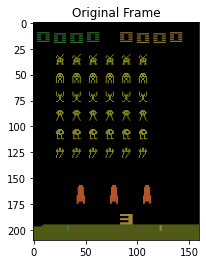

In [4]:
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

In [5]:
def random_play(close_environment = True):
    score = 0
    env.reset()
    while True:
        action = env.action_space.sample()
        _, reward, done, _ = env.step(action)
        score += reward
        if done:
            break
    if close_environment:
      print("Your Score at end of game is: ", score)
      env.close()
    return score

_ = random_play()

Your Score at end of game is:  40.0


In [6]:
rewardRandomAgent = []
for episode in range(1,100):
    rewardRandomAgent.append(random_play(False))
env.close()
print(f"The average reward for the random agent is {np.mean(rewardRandomAgent)}")
        

The average reward for the random agent is 167.62626262626262


# 2. Analyzing the State Space
We wish to understand if the current representation of the state space is correct or if something else should be used. 



In fact, by looking at the image above, we immediately notice that the observation space is much bigger than necessary.
In particular:
  1. Colors don't bring any useful information - so the image can be reduced to grayscale.
  2. The scoreboard at the top is for visual purposes only - so those pixels can be eliminated and the size of the frame can be reduced.
  3. The green portion at the bottom of the frame is useless as well since the space ship sits at the top of it - this can be eliminated as well.

Therefore, we need to preprocess the frames and reduce their complexity which can be done using a wrapper for the environment.

Follwing the approach of DeepMind in their Atari paper, this wrapper converts the image to grayscale, crops the image, normalizes the pixels and resizes the image further to (84 x 84).



In [7]:
class ProcessObservation(gym.ObservationWrapper):
  '''Pre process observation by converting frame from RGB to grayscale and then resizing it to (84 x 84)
  '''
  def __init__(self, env):
    super(ProcessObservation, self).__init__(env)
    self.observation_space = gym.spaces.Box(low = 0, high = 255, shape = (84,84))
    
  def observation(self, color_frame):
    return ProcessObservation.rgb2grayScaled(color_frame)
  
  @staticmethod
  def rgb2grayScaled(color_frame):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray_frame = np.dot(color_frame[...,:3], rgb_weights)
    cropped_frame = gray_frame[25:-12,4:-12]
    cropped_frame = transform.resize(cropped_frame, [84,84])
    return cropped_frame.astype(np.uint8)

We also clip rewards in order to save space and generalize to different games:

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward).astype(np.int16)

# 3. Frame Skipping

Should an agent take an action every frame? Given the speed of the game, two consecutive frames differ very little from the other.

Following the approach of deep mind, for the space invaders game, we skip every 3 frames and repeat the action on the skipped frames.

Furthermore, a maximum is taken over two consecutive frames to ensure that possible blurs or ghosting issues do not cause problems. 

This is implemented in the following wrapper:

In [9]:
# Create our environment wrapper to properly skip the frames.
class MaxAndSkipEnv(gym.Wrapper):

  """
    Each action of the agent is repeated over skip frames        
    return only every `skip`-th frame
  """
  
  def __init__(self, env, skip=3):
    super(MaxAndSkipEnv, self).__init__(env)
    # most recent raw observations (for max pooling across time steps)
    self._obs_buffer = deque(maxlen=2)
    self._skip = skip

  def step(self, action):
    total_reward = 0
    for _ in range(self._skip):
        obs, reward, done, info = self.env.step(action)
        self._obs_buffer.append(obs)
        total_reward += reward
        if done:
            break
    max_frame = np.max(np.stack(self._obs_buffer), axis=0)
    return max_frame, total_reward, done, info

  def reset(self):
    """Clear past frame buffer and init to first obs"""
    self._obs_buffer.clear()
    obs = self.env.reset()
    self._obs_buffer.append(obs)
    return obs

# 4. Frame Stacking

Finally, we also use a technique described in the original Atari paper, which stacks frames in order to obtain a better description of the environment. 

This is because the agent needs a sequence of frames to better understand the motion of the game in order to choose an action. If the monsters are moving left the agent must move left or fire left, and viceversa for the right direction. Without frame stacking, the agent has no idea of the motion. 

Therefore, a state is composed of 4 stacked frames (so it will be an array of size 4 x 84 x 84). 

Remember however, that these frames are not consecutive and are taken every 3 steps (with a max operation).

The following wrapper implements this idea:

In [10]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames

    def toTorch(self):
      return torch.from_numpy(np.stack(self._frames))        

    def __len__(self):
      return len(self.toTorch())

    def __getitem__(self, i):
        return self.toTorch()[i]
    
    def shape(self):
      return self.toTorch().shape

In [11]:
class FrameStack(gym.Wrapper):
  def __init__(self, env, size = 4):
      super(FrameStack, self).__init__(env)
      self.size = size
      self.queue = deque([], maxlen = self.size)
      shp = env.observation_space.shape
      self.observation_space = gym.spaces.Box(low=0, high=255, shape=((size,) + shp), dtype=env.observation_space.dtype)

  def reset(self):
    ob = self.env.reset()
    for _ in range(self.size):
      self.queue.append(ob)
    return self._get_ob()

  def step(self, action):
    ob, reward, done, info = self.env.step(action)
    self.queue.append(ob)
    return self._get_ob(), reward, done, info
  
  def _get_ob(self):
    #return torch.from_numpy(np.stack(self.queue, axis = 0))
    return LazyFrames(list(self.queue))
  

# 5. The final Environment

Finally, by chaining the wrappers in the right order, we can obtain the final environment with states represented just as we want them.

In [12]:
env = gym.make(id='SpaceInvadersNoFrameskip-v4')
env = FrameStack(ClipRewardEnv(MaxAndSkipEnv(ProcessObservation(env))))

A quick check:

In [13]:
print("State size:\t", env.observation_space.shape) #The frame size corresponds to the state space. 
print("Actions:\t ", env.action_space.n)

State size:	 (4, 84, 84)
Actions:	  6


In [14]:
print("Type of state:\t\t\t\t", type(env.reset()))
print("Shape of state as torch tensor:\t\t", env.reset().toTorch().shape)
print("Data type contained in torch tensor:\t", env.reset().toTorch().dtype)

Type of state:				 <class '__main__.LazyFrames'>
Shape of state as torch tensor:		 torch.Size([4, 84, 84])
Data type contained in torch tensor:	 torch.uint8


Let's plot it! (Remember that we can only plot one of the frames so we take the first one)

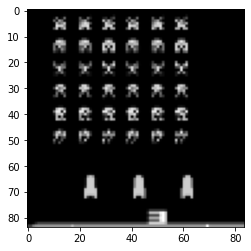

In [15]:
plt.imshow(env.reset().toTorch()[0], 'gray')

To play the game with a random policy, we simply execute the following code:

In [16]:
def random_play_wrappedEnv(close_environment = True):
    score = np.array(0).astype(np.int16)
    env.reset()
    while True:
        action = env.action_space.sample()
        _, reward, done, _ = env.step(action)
        score += reward
        if done:
            print("Your Score at end of game is: ", score)
            break
    if close_environment:
      env.close()

In [17]:
random_play_wrappedEnv()

Your Score at end of game is:  3


# 6. Building the Neural Network

As described in the original paper, the NN consists of:
  - Input layer: (N x 4 x 84 x 84)
  - Hidden layer: 32 8x8 filters with stride 4 and ReLU activation
  - Hidden layer: 64 4x4 filters with stride 2 and ReLU activation
  - Hidden layer: 64 3x3 filters with stride 1 and ReLU activation
  - Hidden Layer: Fully connected layer with 512 neurons
  - Output layer: Fully connected and contains 6 neurons (one for each action)

(where N is the batch size)

In [18]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels = input_shape[0], out_channels = 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(3136,512),
            nn.ReLU(),
            nn.Linear(512,self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.fc(x.view(x.size(0),-1))
        return x

# 7. Experience Replay

One of the most important concepts of the Atari paper by Deep Mind is that of Experience Replay. 

The idea is that we store a transition (state, action, reward, next state) in a queue of fixed size. 
When we want to update the Q function, we sample a random batch of these experiences and apply gradient descent on these observations! 

This extracts more information out of an environment because we don't immediately throw away an observation but we try to get the most of the experiences had so far. 

In [19]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))


class ReplayMemory():

    def __init__(self, capacity = 1000000):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def save(self, episode):
      filename = f"/content/gdrive/MyDrive/Atari/TrainingCheckpoint/memory_{episode}.pt"
      with open(filename, "wb") as fp:
        pickle.dump(self, fp)

    def __len__(self):
        return len(self.memory)
    
    def __iter__(self):
      return ReplayMemoryIterator(self)

class ReplayMemoryIterator():
  def __init__(self, replay_memory):
    self.replaymemory = replay_memory.memory
    self.index = 0
  def __iter__(self):
    return self
  def __next__(self):
    if self.index < len(self.replaymemory):
      transition = self.replaymemory[self.index]
      self.index = self.index + 1
      return transition
    else:
      raise StopIteration

# 9. The Agent

The agent must be able to choose an action according to some policy. In our case, this is an epsilon greedy policy. Following the steps of DeepMind, at each step we decay the exploration linearly from 1.0 to 0.1 until 1 million steps have been taken. At this point we proceed with an exploration of 0.1 until the end of the training. 

The agent must also be able to remember a transition as well as perform an experience replay in order to learn the Q function. 

In the paper, the DeepMind team implemented a hard update of the two networks. In other words, after a certain amount of episodes, the target network would be set to be equal to the policy network. 

We decided to follow another approach discusses in []
where a soft update is implemented. In particular, at each episode, the target network weights get updated as follows:

$Q_{target} = \tau Q_{policy} + (1-\tau) Q_{target}$

where tau is the soft update parameter and its usually set to 0.1%. Therefore, at each step, the target network is updated with 0.1% of the weights of the updated Q function. 
This supposedly has the benefit of stabilizing the training procedure. 


In [20]:
class DQNAgent():

  def __init__(self, state_space_shape, action_space_size, memory_size, batch_size, eps_max, eps_min, 
               schedule_timesteps, discounting, learning_rate, learning_start, update_method,
               soft_update_param = None, update_freq = None, PATH = None, episode = None):
    assert learning_start >= batch_size, f"{learning_start} must be equal or greater than {batch_size}."
 
    # Environment Parameters
    self.state_space_shape = state_space_shape
    self.action_space_size = action_space_size
    self.discounting = discounting
    self.learning_start = learning_start

    # Experience Replay Parameters
    self.memory_size = memory_size
    self.batch_size = batch_size
    
    # Exploration (epsilon greedy) parameters
    self.eps_max = eps_max
    self.eps_min = eps_min
    self.schedule_timesteps = schedule_timesteps

    # Parameters for set up
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #DQN models. 
    self.policy = DQN(state_space_shape, action_space_size).to(self.device)
    self.target = DQN(state_space_shape, action_space_size).to(self.device)
    
    self.method = update_method
    if self.method == "soft":
      assert soft_update_param is not None, "Specify soft update parameter."
      self.soft_update_param = soft_update_param # Target network will be updated as:  soft_update*Q_model + (1-soft_update)*Q_target
    elif self.method == "hard":
      assert update_freq is not None, "Specify update frequency."
      self.update_freq = update_freq

    # Parameters for neural network
    self.learning_rate = learning_rate
    self.optimizer = torch.optim.Adam(self.policy.parameters(), lr = self.learning_rate)
    self.loss = nn.SmoothL1Loss().to(self.device)


    if PATH is not None:
      checkpoint = torch.load(PATH)
      self.policy.load_state_dict(checkpoint['policy_state_dict'])
      self.optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
      self.target.load_state_dict(checkpoint['target_state_dict'])
      self.step = checkpoint['step']
      self.eps_current = checkpoint['eps_current']
      if episode is not None:
        with open(f"/content/gdrive/MyDrive/Atari/TrainingCheckpoint/memory_{episode}.pt", "rb") as fp:
          self.memory = pickle.load(fp)
      else:
          self.memory = ReplayMemory(capacity = self.memory_size)
    else:
      self.step = 0
      self.memory = ReplayMemory(capacity = self.memory_size)
      self.eps_current = eps_max

  def remember(self, state, action, reward, next_state, done):
    '''Remember an experience'''
    self.memory.push(state,action,reward,next_state,done)

  def epsilon_greedy(self, state):
    '''epsilon greedy strategy to choose best action'''
    self._decrease_exploration()
    if random.random() > self.eps_current:
      with torch.no_grad():
        return int(torch.argmax(self.policy(state.toTorch().unsqueeze(0).to(self.device).to(torch.float))).cpu())
    else:
      return random.randrange(self.action_space_size)
    
  def act(self, state, epsilon):
    if random.random() > epsilon:
      with torch.no_grad():
        return int(torch.argmax(self.policy(state.toTorch().unsqueeze(0).to(self.device).to(torch.float))).cpu())
    else:
      return random.randrange(self.action_space_size)


  def experience_replay(self):
    if len(self.memory) < self.learning_start:
      # Need to acquire more experience
      return
    experiences = self.memory.sample(self.batch_size)

    experiences = Transition(*zip(*experiences))
    #tuple of lazy frames
    next_state_batch = [next_state.toTorch() for next_state in experiences.next_state]
    next_state_batch = torch.stack(next_state_batch).to(self.device)
    reward_batch     = torch.tensor(experiences.reward).to(self.device) # size 32
    done_batch       = torch.tensor(experiences.done, dtype = torch.int).to(self.device)

    with torch.no_grad():
      max_a = torch.argmax(self.policy(next_state_batch.to(torch.float)), axis = 1).unsqueeze(1)
      target = reward_batch + self.discounting * torch.mul(self.target(next_state_batch.to(torch.float)).gather(1, max_a).squeeze(), 1-done_batch)
    
    del next_state_batch
    del reward_batch
    del done_batch
    del max_a
    
    state_batch      = [state.toTorch() for state in experiences.state]
    state_batch      = torch.stack(state_batch).to(self.device)
    
    action_batch     = torch.tensor(experiences.action).unsqueeze(1).to(self.device)
    
    self.optimizer.zero_grad()
    loss = self.loss(target, self.policy(state_batch.to(torch.float)).gather(1, action_batch).squeeze())

    loss.backward()
    self.optimizer.step()

    del state_batch
    del action_batch
    del target
    
    self._update()
    
  def _decrease_exploration(self):
    fraction = min(self.step/self.schedule_timesteps, 1.0)
    
    self.eps_current = (self.eps_min-self.eps_max)*fraction + self.eps_max

    self.step += 1 # Everytime we decrease exploration, we are choosing an action thus taking another step.
    return
  
  def _update(self):
    if self.method == "soft":
      return self._soft_udpate_target()
    elif self.method == "hard":
      return self._hard_update_target()
    else:
      print(f"Update method not recognized. Choose between 'soft' or 'hard'")
  
  def _soft_udpate_target(self):
    for target_param, param in zip(self.target.parameters(), self.policy.parameters()):
        target_param.data.copy_(self.soft_update_param*param.data + target_param.data*(1.0 - self.soft_update_param))
    return

  def _hard_update_target(self):
    if (self.step-self.learning_start)%self.update_freq == 0:
      self.target.load_state_dict(self.policy.state_dict())
    
  def show_status(self, episode, avg_reward):
    print(f"Episode {episode} completed. Average Reward: {avg_reward}")


  def save(self, episode, total_rewards, duration):
    filename = f"/content/gdrive/MyDrive/Atari/TrainingCheckpoint/dqnAgent_{episode}.pt"
    torch.save({
            'episode' : episode,
            'total_rewards': total_rewards,
            'duration': duration,
            'step': self.step,
            'eps_current': self.eps_current,
            'policy_state_dict': self.policy.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'target_state_dict': self.target.state_dict()
            }, filename)
    self.memory.save(episode)


# 10. Training

We finally implement the function to train the agent over 2 thousand episodes. 
At each episode, we save the state of the agent (both networks and the optimizer for the policy network), the episode, the array of total rewards, and the array of average rewards over the episodes. 

In [21]:
def trainAgent(episodes = 2000, skipsteps = 1):
  agent = DQNAgent(
      state_space_shape = [4,84,84],
      action_space_size = 6,
      memory_size = 50000,
      batch_size = skipsteps*32,
      eps_max = 1.0,
      eps_min = 0.02,
      schedule_timesteps = 10000,
      discounting = 0.99,
      learning_rate = 5e-4,
      learning_start = 5000,
      update_method= "soft",
      soft_update_param = 0.002
      )
  total_rewards = []
  duration = []
  for episode in range(1, episodes):
    state = env.reset()
    total_reward = np.array(0).astype(np.int16)
    steps = 0
    skipsteps = skipsteps
    while True:
      
      #sample action using epsilon greedy
      action = agent.epsilon_greedy(state)

      #take action and receive reward and next state
      next_state, reward, done, _ = env.step(action)
      total_reward += reward
      steps += 1
      skipsteps -= 1
      
      #store experience
      agent.remember(state,action,reward,next_state,done)

      #Experience Replay to update Policy model
      if skipsteps==0:
        agent.experience_replay()
        skipsteps = 4
      
      state = next_state
      if done:
        break
      
    total_rewards.append(total_reward)
    duration.append(steps)

    if episode%500 == 0:
      agent.save(episode, total_rewards, duration)

In [22]:
# Uncomment for training. Warning! Requires a lot of RAM.
#env = gym.make(id='SpaceInvadersNoFrameskip-v4')
#env = FrameStack(ClipRewardEnv(MaxAndSkipEnv(ProcessObservation(env))))
#trainAgent(skipsteps = 4)

# 11. Results

It is a well known fact from literature that these algorithms are very sensitive to parameters. We ran various test cases and situations based on what we found online as possible suggestions from past literature. 

Below are the various runs (note that for all runs eps_max = $1.0$): 
- Run 1: In this run, we had not yet introduced the parameter "learning_start" which indicates after how many steps the agent should begin to learn. In fact, in our previous implementation, as soon as the memory had stored enough for the first batch, we began to learn. This possibly caused overfitting to the first 32 experiences which resulted in negative results as can be seen by the low performance which decreases as the episodes increased.
In terms of the hyperparameters, we used:
    - learning_rate: $1e-3$
    - memory_size: $1e6$
    - schedule_timesteps: $1e6$
    - eps_min: $0.1$
    - soft_update_param: $0.001$
    
        Clearly, we suffered from overfitting and from lack of exploration.
- Run 2: In this run, we introduced the learning starts parameter. We also took inspiration from the OpenAI baselines and reduced the size of the buffer and the schedule time steps. We also reduced eps min. The parameters were as follows:
    - learning_rate: $5e-4$
    - memory_size: $5e4$
    - schedule_timesteps: $1e4$
    - eps_min: $0.02$
    - soft_update_param: $0.002$
    - learning_starts: $1e3$
    
        This run provided a good performance in terms of peak increase. However, after 8000 episodes, it was clear that it hadn't explored enough and had settled for an average performance of around 16 points.
- Run 3: Aiming to improve the lack of exploration in the above run, we increased the memory size and the schedule timesteps as well as the eps_min.
    - learning_rate: $5e-4$
    - memory_size: $5e5$
    - schedule_timesteps: $5e5$
    - eps_min: $0.1$
    - soft_update_param: $0.002$
    - learning_starts: $1e3$
    
        This however, proved to give too much exploration and the results were less performant than the previos run.
- Run 4: We decided to take inspiration from a blog post to accelerate the learning by introducing a skip_steps parameter. This parameter indicates how many steps the agent should take before doing a learning iteration. The idea was to give more exploration to the agent while also increasing the batch size proportionally by the number of steps skipped between learning loops.
    - learning_rate: $5e-4$
    - memory_size: $1e5$
    - schedule_timesteps: $1e5$
    - eps_min: $0.05$
    - soft_update_param: $0.002$
    - skipsteps: $4$
    - learning_starts: $5e3$

- Run 5: During this run we used the same setting as Run2 but with the skipstep technique to increase exploration. 
    - skipsteps: $4$

        This run was the best in terms of performance. It seemed to be more efficient at learning than all the other methods and it was also much quicker in doing so.
- Run 6: To further explore some other configurations, we decided to not clip the rewards and do a hard update instead of a soft update. The hope was that the drastic change of the target after N steps would help increase learning. However, this came at the risk of also creating too much instability. We used the same parameters as run 2.
    - update_method: "hard"
    - update_frequency: $10e4$

In all cases, we stopped the training as soon as we saw evidence of flattening. In all cases, we did not train for 10 millions steps as done in the Nature paper since we were aiming at exploring configurations without wasting too many computational resources. 


Below we show the results:

In [3]:
results1 = torch.load("./Results/dqnAgentRUN1_3000.pt")
results2 = torch.load("./Results/dqnAgentRUN2_8000.pt")
results3 = torch.load("./Results/dqnAgentRUN3_9500.pt")
results4 = torch.load("./Results/dqnAgentRUN4_6000.pt")
results5 = torch.load("./Results/dqnAgentRUN5_7000.pt")
results6 = torch.load("./Results/dqnAgentHARDRUN6_6500.pt")



In [4]:
tot1 = results1["total_rewards"]
tot2 = results2["total_rewards"]
tot3 = results3["total_rewards"]
tot4 = results4["total_rewards"]
tot5 = results5["total_rewards"]
tot6 = results6["total_rewards"]


avg1 = []
avg2 = []
avg3 = []
avg4 = []
avg5 = []
avg6 = []

for i in range(1,len(tot1)):
    avg1.append(np.mean(tot1[:i]))
for i in range(1,len(tot2)):
    avg2.append(np.mean(tot2[:i]))
for i in range(1,len(tot3)):
    avg3.append(np.mean(tot3[:i]))
for i in range(1,len(tot4)):
    avg4.append(np.mean(tot4[:i]))
for i in range(1,len(tot5)):
    avg5.append(np.mean(tot5[:i]))
for i in range(1,len(tot6)):
    avg6.append(np.mean(tot6[:i]))

The max reward for run5 is: 17.0975468975469 at 3464 episodes


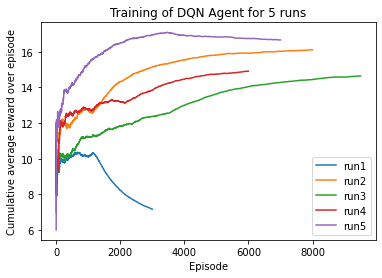

In [5]:
print(f"The max reward for run5 is: {max(avg5)} at {np.argmax(avg5)} episodes")

plt.plot(avg1, label = "run1")
plt.plot(avg2, label = "run2")
plt.plot(avg3, label = "run3")
plt.plot(avg4, label = "run4")
plt.plot(avg5, label = "run5")
#plt.axvline(x = 3500)
plt.xlabel("Episode")
plt.ylabel("Cumulative average reward over episode")
plt.title("Training of DQN Agent for 5 runs")
ax = plt.gca()
ax.legend()
plt.show()

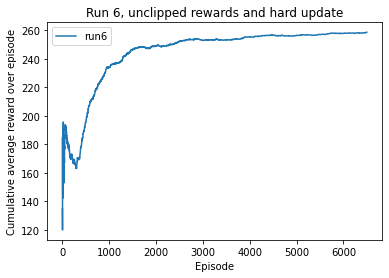

In [26]:
plt.plot(avg6, label = "run6")
plt.xlabel("Episode")
plt.ylabel("Cumulative average reward over episode")
plt.title("Run 6, unclipped rewards and hard update")
ax = plt.gca()
ax.legend()
plt.show()



In [27]:
def watchAgent(PATH, episodes):
  agent = DQNAgent(
      state_space_shape = [4,84,84],
      action_space_size = 6,
      memory_size = 50000,
      batch_size = 32,
      eps_max = 1.0,
      eps_min = 0.02,
      schedule_timesteps = 10000,
      discounting = 0.99,
      learning_rate = 5e-4,
      learning_start = 5000,
      update_method= "soft",
      soft_update_param = 0.002,
      PATH = PATH
      )
  total_rewards = []

  for episode in range(1, episodes):
    state = env.reset()
    total_reward = 0
    while True:
      #sample action using epsilon greedy
      action = agent.act(state, 0.05)

      #take action and receive reward and next state
      next_state, reward, done, _ = env.step(action)
      total_reward += reward
      state = next_state

      if done:
        break
    total_rewards.append(total_reward)

    if episode%20 == 0:
      agent.show_status(episode, total_reward)
      
  return total_rewards

In [28]:
env = gym.make(id='SpaceInvadersNoFrameskip-v4')
env = FrameStack(MaxAndSkipEnv(ProcessObservation(env))) # no reward clipping to watch agent!

total_rewards = watchAgent(PATH = "./Results/dqnAgentRUN5_3500.pt", episodes = 100)


Episode 20 completed. Average Reward: 225.0
Episode 40 completed. Average Reward: 330.0
Episode 60 completed. Average Reward: 235.0
Episode 80 completed. Average Reward: 220.0


In [29]:
print(f"The average reward for the random agent is: \t\t{np.mean(rewardRandomAgent)}")
print(f"The average reward for the best dqn agent is: \t\t{np.mean(total_rewards)}")



The average reward for the random agent is: 		167.62626262626262
The average reward for the best dqn agent is: 		289.34343434343435


This means an improvement of $\approx 120$ points!

Works Cited:

- The original paper of DQN:
      
    https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

- Slides from David Silvers course:

    https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf

- An explanation of frame stacking:

    https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/

- The pytorch implementation of DQN: 

    https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

- An implementation of DQN by Chao De-Yu:

    https://towardsdatascience.com/deep-q-network-with-pytorch-146bfa939dfe

- The paper in which soft updating was used first:

    https://arxiv.org/pdf/1509.02971.pdf

- An explanation of soft updating:

    https://ai.stackexchange.com/questions/21485/how-and-when-should-we-update-the-q-target-in-deep-q-learning

- A introduction to OpenAI's gym environment:

    https://blog.paperspace.com/getting-started-with-openai-gym/

- An overview of the Space Invaders environment:

    https://www.gymlibrary.ml/environments/atari/space_invaders/

- OpenAI baseline for environment wrappers. Lazy Frames taken from here to save space:

    https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

- Results obtained from a competition:

    https://wandb.ai/raghmura/qualcomm/reports/Space-Invaders-challenge-a-Reinforcement-Learning-competition--Vmlldzo5MzEzMg

Individual Contributions:
- Idea: Davide + Andres
- Slides: Davide
- Initial setup code and environment: Davide + Andres
- Tweaks and training: Andres
- Runs: Andres + Davide

